# Image Classification Model v1 for Corak App

## Overview
This notebook contains all of the codes and steps needed to build a Machine Learning model for classifiying Batik motives.

In this case, we're gonna be using image dataset from Kaggle which has almost 1000 Batik motives images in 20 different classes. You can access the dataset through this [link](https://www.kaggle.com/dionisiusdh/indonesian-batik-motifs).

For a quick preview, here's all of the available Batik motives that we will classify later on.

No. | Motive name | No. | Motive Name
--- | --- | --- | ---
1. | Batik Bali | 11. | Batik Lasem
2. | Batik Betawi | 12. | Batik Mega Mendung
3. | Batik Celup | 13. | Batik Parang
4. | Batik Cendrawasih | 14. | Batik Pekalongan
5. | Batik Ceplok | 15. | Batik Priangan
6. | Batik Ciamis | 16. | Batik Sekar
7. | Batik Garutan | 17. | Batik Sidoluhur
8. | Batik Gentongan | 18. | Batik Sidomukti
9. | Batik Kawung | 19. | Batik Sogan
10. | Batik Keraton | 20. | Batik Tambal

Without further ado, let's jump into the code!



## Dependencies
There are some dependency/library that we need to install (in case you haven't) to initiate this project.
* [kaggle](https://pypi.org/project/kaggle/) --> to download the dataset through the Kaggle API
* [tensorflow](https://www.tensorflow.org/install/pip) --> to build the neural network model
* [matplotlib](https://matplotlib.org/stable/users/installing.html) --> to visualize necessary info
* [scipy](https://www.scipy.org/install.html) --> to transform image while training (required by tensorflow)

To install those dependencies, we'll use `!pip install <dependency>` in the following cell.

In [6]:
!pip install kaggle tensorflow matplotlib scipy Pillow

## Acquire data
First of, let's collect the dataset using Kaggle API. Please be noticed that we'll need a kaggle.json file. You can see the API Credentials Instruction [here](https://github.com/Kaggle/kaggle-api#api-credentials).

After downloading the kaggle.json file into our current working directory, execute the following code.


In [9]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the file permission to avoid warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Now, we're ready to download the dataset from this [Batik motives dataset](https://www.kaggle.com/dionisiusdh/indonesian-batik-motifs) using the Kaggle API that we've already installed.

The download process will took a while. Once it's done, you'll get `indonesian-batik-motifs.zip` file. We then unzip the file into a separate folder called `dataset/`.

In [12]:
!kaggle datasets download -d dionisiusdh/indonesian-batik-motifs

100%|████████████████████████████████████████| 262M/262M [03:29<00:00, 1.68MB/s]
100%|████████████████████████████████████████| 262M/262M [03:29<00:00, 1.31MB/s]
indonesian-batik-motifs.zip model.ipynb
kaggle.json


In [22]:
# List out our current working directory files
!ls -l

total 559112
-rw-r--r--  1 alfanme  staff  275184144 May  7 09:58 indonesian-batik-motifs.zip
-rw-r--r--  1 alfanme  staff         63 May  7 09:48 kaggle.json
-rw-r--r--  1 alfanme  staff          0 May  7 08:52 model.ipynb


In [23]:
# Unzip file into dataset folder
!unzip indonesian-batik-motifs.zip -d dataset

ik-lasem/45.jpg  
  inflating: dataset/batik-lasem/46.jpg  
  inflating: dataset/batik-lasem/47.jpg  
  inflating: dataset/batik-lasem/48.jpg  
  inflating: dataset/batik-lasem/49.jpg  
  inflating: dataset/batik-lasem/5.jpg  
  inflating: dataset/batik-lasem/50.jpg  
  inflating: dataset/batik-lasem/6.jpg  
  inflating: dataset/batik-lasem/7.jpg  
  inflating: dataset/batik-lasem/8.jpg  
  inflating: dataset/batik-lasem/9.jpg  
  inflating: dataset/batik-megamendung/1.jpg  
  inflating: dataset/batik-megamendung/10.jpg  
  inflating: dataset/batik-megamendung/12.jpg  
  inflating: dataset/batik-megamendung/13.jpg  
  inflating: dataset/batik-megamendung/14.jpg  
  inflating: dataset/batik-megamendung/15.jpg  
  inflating: dataset/batik-megamendung/16.jpg  
  inflating: dataset/batik-megamendung/17.jpg  
  inflating: dataset/batik-megamendung/18.jpg  
  inflating: dataset/batik-megamendung/19.jpg  
  inflating: dataset/batik-megamendung/2.jpg  
  inflating: dataset/batik-megamendung/20

In [10]:
import os

dataset_dir = 'dataset/'
training_dir = 'tmp/training'
testing_dir = 'tmp/testing'

# Create sub-directories for all Batik motives inside the training and testing dir
batik_motives = os.listdir(dataset_dir)

if not os.path.exists('./tmp'):
    for motive in batik_motives:
        os.makedirs(os.path.join(training_dir, motive))
        os.makedirs(os.path.join(testing_dir, motive))
    print('Directories created.')
else:
    print('The directories already exist.')

Directories created.


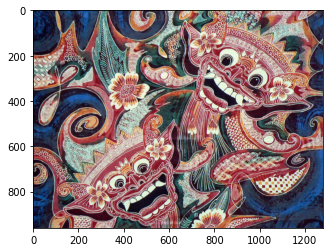

(960, 1280, 3)
<class 'numpy.ndarray'>


In [7]:
# See image example from dataset/ directory
import matplotlib.pyplot as plt

image = plt.imread('dataset/batik-bali/1.jpg')
plt.imshow(image)
plt.show()
print(image.shape)
print(type(image))

In [11]:
# Shuffle, split, and copy files
# from dataset/ into tmp/training and tmp/testing
import numpy as np
import shutil
from PIL import Image

def get_train_test_split(motive):

    dataset_motive_dir = os.path.join(dataset_dir, motive)
    motive_files = np.array(os.listdir(dataset_motive_dir))
    np.random.shuffle(motive_files)
    
    training_size = int(0.85 * len(motive_files))

    training_set = motive_files[:training_size]
    testing_set = motive_files[training_size:]

    tmp_training_dir = os.path.join(training_dir, motive)
    tmp_testing_dir = os.path.join(testing_dir, motive)

    return training_set, testing_set, dataset_motive_dir, tmp_training_dir, tmp_testing_dir

for motive in batik_motives:
    print(f'Copying {motive} from dataset/ to tmp/training and tmp/testing')
    training_set, testing_set, dataset_motive_dir,\
        tmp_training_dir, tmp_testing_dir = get_train_test_split(motive)
    print(f'Split size: {len(training_set)} training, {len(testing_set)} testing')

    # Copy the training_set to tmp/training
    for image_file in training_set:
        source = os.path.join(dataset_motive_dir, image_file)
        destination = os.path.join(tmp_training_dir, image_file)
        try:
          image = Image.open(source)
          image.verify()
          shutil.copy(source, destination)
        except (IOError, SyntaxError) as e:
            print(image_file, e)
            continue

    # Copy the testing_set to tmp/testing
    for image_file in testing_set:
        source = os.path.join(dataset_motive_dir, image_file)
        destination = os.path.join(tmp_testing_dir, image_file)
        try:
          image = Image.open(source)
          image.verify()
          shutil.copy(source, destination)
        except (IOError, SyntaxError) as e:
            print(image_file, e)
            continue

    print('>> DONE')

print('All work DONE, all image files are shuffled, splitted, and ready to use.')

Copying batik-cendrawasih from dataset/ to tmp/training and tmp/testing
Split size: 42 training, 8 testing
.DS_Store cannot identify image file 'dataset/batik-cendrawasih/.DS_Store'
>> DONE
Copying batik-bali from dataset/ to tmp/training and tmp/testing
Split size: 42 training, 8 testing
>> DONE
Copying batik-betawi from dataset/ to tmp/training and tmp/testing
Split size: 42 training, 8 testing
>> DONE
Copying batik-sidoluhur from dataset/ to tmp/training and tmp/testing
Split size: 42 training, 8 testing
>> DONE
Copying batik-kawung from dataset/ to tmp/training and tmp/testing
Split size: 38 training, 7 testing
>> DONE
Copying batik-garutan from dataset/ to tmp/training and tmp/testing
Split size: 41 training, 8 testing
.DS_Store cannot identify image file 'dataset/batik-garutan/.DS_Store'
>> DONE
Copying batik-priangan from dataset/ to tmp/training and tmp/testing
Split size: 42 training, 8 testing
.DS_Store cannot identify image file 'dataset/batik-priangan/.DS_Store'
>> DONE
Cop

## Let's start building the Machine Learning model
We've already split the image data into training and testing directories. Now, it's time to start working with *Tensorflow* library to build our Machine Learning model.

In [26]:
# Import all the dependencies
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
import scipy

In [44]:
# Data augmentation & normalization/rescaling
train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.5,
      zoom_range=0.5,
      fill_mode='nearest',
      horizontal_flip=True,
      vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory="tmp/training",
    target_size=(112,112),
    class_mode='categorical',
    batch_size=20
)

validation_generator = validation_datagen.flow_from_directory(
    directory="tmp/testing",
    target_size=(112,112),
    class_mode='categorical',
    batch_size=20
)

Found 810 images belonging to 20 classes.
Found 155 images belonging to 20 classes.


In [50]:
clear_session()

model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(112, 112, 3)),
    MaxPool2D(2, 2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(20, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    shuffle=True,
    epochs=10
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1605664   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2

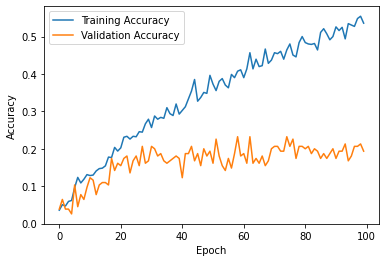

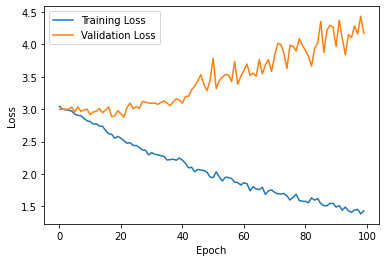

In [51]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()